In [112]:
import keras
from keras.models import load_model
import os
import utils
from keras.layers import Softmax, ReLU #, argmax
from metrics.miou import MeanIoU
from keras.models import Model
import cv2
import numpy as np
from matplotlib import gridspec
from matplotlib import pyplot as plt

In [113]:
curr_dir = os.getcwd()
print(curr_dir)

/qutub/models/semantic_segmentation_models-fast_scnn/fast-scnn


In [114]:
nb_classes = 34
input_size = [384, 1248]
input_layer = keras.layers.Input(shape=(input_size[0],input_size[1],3),  name = 'input_layer', dtype = 'float32' )


lds_layer = utils.conv_block(input_layer, 'conv', 32, (3, 3), strides = (2, 2))
lds_layer = utils.conv_block(lds_layer, 'ds', 48, (3, 3), strides = (2, 2))
lds_layer = utils.conv_block(lds_layer, 'ds', 64, (3, 3), strides = (2, 2))

"""## Step 2: Global Feature Extractor

"""

"""#### Assembling all the methods"""

gfe_layer = utils.bottleneck_block(lds_layer, 64, (3, 3), t=6, strides=2, n=3) 
gfe_layer = utils.bottleneck_block(gfe_layer, 96, (3, 3), t=6, strides=2, n=3)
gfe_layer = utils.bottleneck_block(gfe_layer, 128, (3, 3), t=6, strides=1, n=3)
gfe_layer = utils.pyramid_pooling_block(gfe_layer, [2,4,6,8])

"""## Step 3: Feature Fusion"""

ff_layer1 = utils.conv_block(lds_layer, 'conv', 128, (1,1), padding='same', strides= (1,1), relu=False)

ff_layer2 = keras.layers.UpSampling2D((4, 4))(gfe_layer)
ff_layer2 = keras.layers.DepthwiseConv2D(128, strides=(1, 1), depth_multiplier=1, padding='same')(ff_layer2)
ff_layer2 = ReLU()(ff_layer2) ## as some authors suggest BN after activation layer sounds more logical in statistical POV
ff_layer2 = keras.layers.BatchNormalization()(ff_layer2)
ff_layer2 = keras.layers.Conv2D(128, kernel_size = 1, strides=1, padding='same', activation=None, kernel_regularizer=keras.regularizers.l2(0.00004))(ff_layer2)

ff_final = keras.layers.add([ff_layer1, ff_layer2])
ff_final = keras.layers.BatchNormalization()(ff_final)
ff_final = ReLU()(ff_final)

"""## Step 4: Classifier"""

classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv1_classifier')(ff_final)
classifier = ReLU()(classifier)
classifier = keras.layers.BatchNormalization()(classifier)


classifier = keras.layers.SeparableConv2D(128, (3, 3), padding='same', strides = (1, 1), name = 'DSConv2_classifier')(classifier)
classifier = ReLU()(classifier)
classifier = keras.layers.BatchNormalization()(classifier)


classifier = utils.conv_block(classifier, 'conv', nb_classes, (1, 1), strides=(1, 1), padding='same', relu=True)

classifier = keras.layers.Dropout(0.3)(classifier)

classifier = keras.layers.UpSampling2D((8, 8))(classifier)
classifier = Softmax(axis=-1)(classifier)
fast_scnn = Model(inputs = input_layer , outputs = classifier, name = 'Fast_SCNN')




(?, 12, 39, 128)
39
12





In [116]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
  
    'unlabeled', 'ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground',
    'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail',
    'bridge', 'tunnel', 'pole', 'polegroup', 'traffic light', 'traffic sign', 'vegetation', 'terrain',
    'sky', 'person', 'rider', 'car', 'truck', 'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [ ]:
#weights_path = curr_dir+'/dataset/kitti_seg/export/weigths'
weights_path = curr_dir+'/dataset/kitti_seg/export/weights'
#data_path = curr_dir+'/dataset/kitti_seg/data_semantics/testing/image2/000000_10.png'
data_path = curr_dir+'/dataset/kitti_seg/data_semantics/training/image_2/000024_10.png'
print(weights_path)
print(os.path.isdir(weights_path))
print(os.path.isfile(data_path))
#os.listdir(weights_path)
target_size = [384, 1248]
im = cv2.imread(data_path , 1 )
im_0 = cv2.resize(im,(target_size[1],target_size[0]))
im = np.expand_dims(im_0, axis=0)

In [106]:
#model = load_model(weights_path +'/model_weights-138-0.47.h5')
fast_scnn.load_weights(weights_path +'/model_weights-138-0.47.h5')

In [117]:
im_0.shape
from scipy.special import softmax

In [108]:
pred = fast_scnn.predict(im)
preds = np.argmax(pred, axis=3)
Pred = np.squeeze(preds, axis=0)

In [119]:
m = softmax(pred, axis=3)
m.shape

(1, 384, 1248, 34)

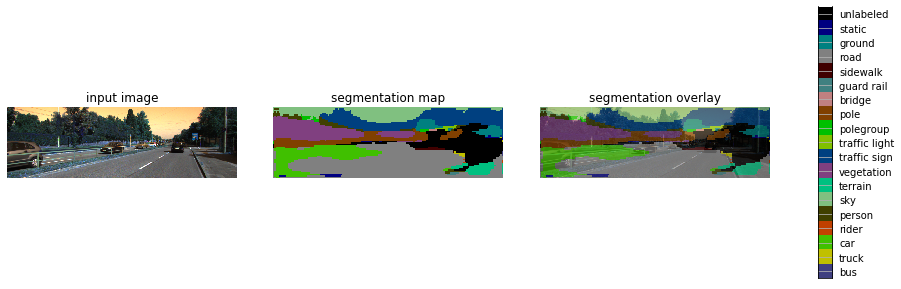

In [109]:
vis_segmentation(im_0,Pred)